In [1]:
from stock_env.algos.agent import Agent
from stock_env.envs import *
from stock_env.common.common_utils import open_config
from stock_env.common.env_utils import make_vec_env
import torch as th
from stock_env.common.common_utils import create_performance, plot_trade_log_v2
from stock_env.common.evaluation import play_an_episode, evaluate_agent
from stock_env.common.common_utils import open_config
import seaborn as sns
sns.set()
import plotly.graph_objects as go

def buy_and_hold_plot(df, algo_name, init_cash=1000000):
    import vectorbt as vbt
    
    # portfolio value from hodling
    df["pv_from_holding"] = vbt.Portfolio.from_holding(
        df.close, init_cash=init_cash
    ).value()
    df = df.set_index("time")
    ticker = df["ticker_x"].unique()[0]
    
    fig = go.Figure()
    fig.update_layout(width=800, height=500)
    fig.update_layout(title=f"Buy-n-Hold Comparision, Ticker: {ticker}", title_x=0.5)
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Portfolio Value ($)")

    df["portfolio_value"].vbt.plot_against(
        other=df["pv_from_holding"],
        other_trace_kwargs=dict(
            line=dict(width=2, color="dimgray"), mode="lines", name="Buy-n-Hold"
        ),
        trace_kwargs=dict(
            mode="lines+markers",
            line=dict(width=3, color="lightslategray"),
            name=algo_name,
        ),
        pos_trace_kwargs=dict(fillcolor="palegreen"),
        neg_trace_kwargs=dict(fillcolor="salmon"),
        fig=fig,
    )
    fig.show()

In [2]:
env_id = "VNALL-v0"
model_path = "../model/ppo_adapt_SSI_20230102_133152.pth"
config_path = "../configs/ppo_adapt.yaml"

# setting up
args = open_config(config_path, env_id=env_id)
envs = make_vec_env(env_id, num_envs=1, task=args.task)
agent = Agent(envs, hiddens=args.hiddens)
random_agent = Agent(envs, hiddens=args.hiddens)
agent.load_state_dict(th.load(model_path))

<All keys matched successfully>

In [3]:
eval_envs = make_vec_env(env_id, num_envs=args.num_envs, task=args.task)
eval_envs.train(False)
mean, std = evaluate_agent(agent=random_agent, envs=eval_envs, n_eval_episodes=args.n_eval_episodes)
print(f"Mean reward: {mean:.2f} +/- {std: .2f}")
mean, std = evaluate_agent(agent=agent, envs=eval_envs, n_eval_episodes=args.n_eval_episodes)
print(f"Mean reward: {mean:.2f} +/- {std: .2f}")

Mean reward: -6.40 +/-  12.84
Mean reward: -12.02 +/-  52.45


Ticker: SSI, from date 2021-11-03 00:00:00 to date 2022-11-03 00:00:00

    Annual return     : -46.79%
    Cumulative return : -46.52%
    Sharpe ratio      : -1.40
    Maximum Drawdown  : -53.15%
    Annual Volatility :  39.58%
    Value-At-Risk     :  nan%
    


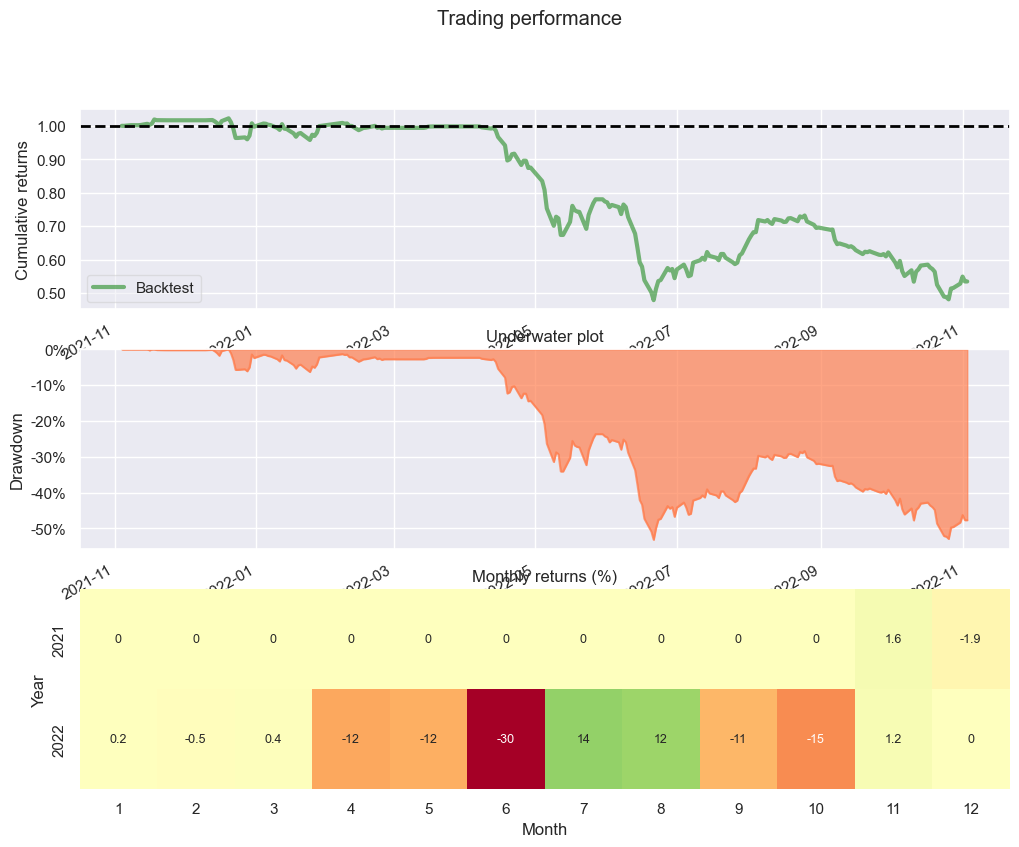

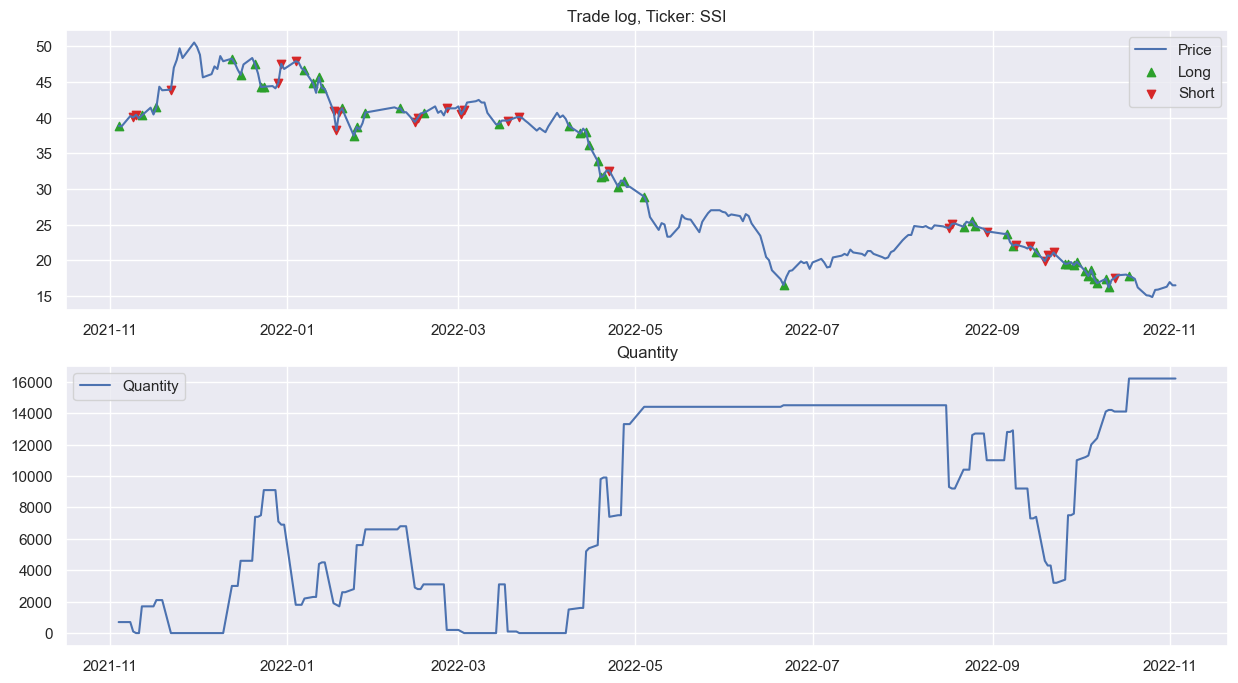

In [12]:
# _agent = random_agent
_agent = agent

# evaluate
envs.train(False)
info = play_an_episode(_agent, envs)
df = info["final_info"][0]["final_history"]
returns = df.set_index("time")["portfolio_value"].pct_change()
results = create_performance(returns)
plot_trade_log_v2(df)

buy_and_hold_plot(df, "PPO_adapt", init_cash=envs.envs[0].init_cash)